### Scikit-Learn Machine Learning and Tableau Data Visualization Project

This project examines the Greater Richmond Transit Company (GRTC) Ridership Data to inform GRTC stakeholders of key characteristics of a Ridership Survey Collection Plan that maximizes rider input while minimizing collection costs. The Machine Learning portion seeks to classify "Nulls" currently listed for "SERVICE_TYPE" (local vs express) to be used "down stream" in the bus-stop selection process. 

### Frame the problem and look at the big picture

#### BACKGROUND:
Greater Richmond Transit Company is a non-profit organization that provides transportation services to the Richmond VA area and parts of Chesterfield and Henrico counties. These include fixed route and express route bus service (along with specialized services such as CARE and C-VAN, and RideFinders). 

GRTC has undergone extensive changes over the last few years include  expanded routes and operating hours to better achieve its vision of becoming the leading provider of world class transportation services and mobility solutions through Central Virginia. These changes affect multiple stakeholders and include: 

 - Richmond Transit Network Plan overhaul which included the GRTC Pulse (a Bus Rapid Transit initiative) 
 - Henrico enhanced public transit service to increase access to jobs, shopping and other services throughout the county
 -  VCU pilot program (a partnership with VCU to increase access for VCU students)

Together these changes have reversed the trend experienced nationally of declining ridership. Instead, GRTC ridership has been increasing since throughout 2019.

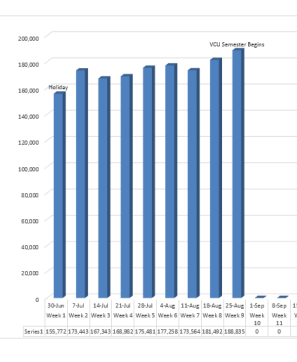


#### Project Scope:
This project will examine GRTC ridership (by route and stops) in order to inform a future Ridership Survey intended to capture GRTC Rider Sentiment. 

#### ProblemStatement: 
What survey design factors are required to best capture GRTC Rider Sentiment while minimizing the costs associated with executing the survey? 

#### The Ask: 
Develop a survey collection plan that maximizes input from riders across GRTC's multiple routes and operating hours while minimizing the cost of collection.

#### The Machine Learning portion of the project will use the following framework:

- Get the data.
- Explore the data to gain insights (Tableau Prep, Tableau and Python libraries).
- Prepare the data to better expose the underlying data patterns to Machine Learning algorithms (Python Scikit-Learn).
- Explore different models and short-list the best one(s) (Python Scikit-Learn).
- As needed: Fine tune the short-listed model(s) and combine (if practical) into the best solution (Python Scikit-Learn).



### Get the data
This project started with a request to GRTC leadership for "transactional level data."  GRTC put the project team in contact with one of their analysts who (through a series of conversations) provided over a year's worth of data on ridership and on-time performance.  

### Explore the data to gain insights

In [1]:
# Dependencies

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import pydot 

from sklearn import tree
from sklearn.tree import export_graphviz


# from sklearn.externals import joblib
# from joblib import dump, load

#### Conduct Data Cleaning and Munging in Tableau Prep
Tableau Prep was used to combine files, clean data and reduce the number of columns in the original files received from GRTC from around 25 to the 8 listed below. The output of Tableau Prep was a csv file to read into Pandas as a DataFrame.

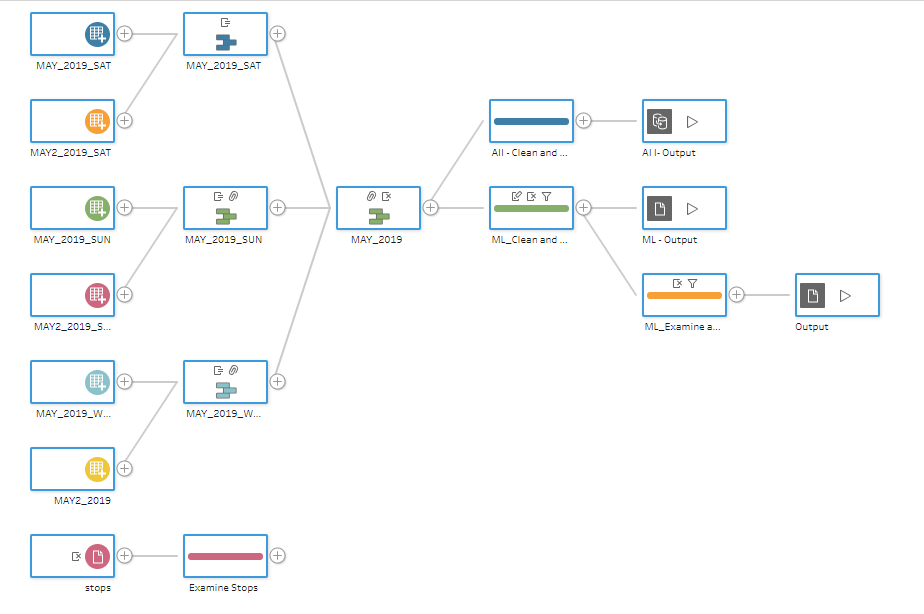


In [2]:
# Read the CSV file created in Tableau Prep for Machine Learning
# Examine the classes of each variable
# NOTE: All are numbers except the "SERVICE_TYPE" which is the varible the Machine Learning is trying to predict

GRTC_Ridership_df = pd.read_csv('.\Tableau Prep Output\ML_Plot_May_2019_with_Clean_Lat_Lon.csv')
GRTC_Ridership_df.dtypes

TRIPS_COUNT              int64
AVG_SERVICED           float64
MAX_LOAD                 int64
AVG_PASSENGER_MILES    float64
AVG_SEGMENT_MILES      float64
LAT                    float64
LON                    float64
SERVICE_TYPE            object
dtype: object

#### Examine Data using standard Pandas commands (i.e. shape, info, value_counts, describe)


In [3]:
GRTC_Ridership_df.shape

(12700, 8)

In [4]:
GRTC_Ridership_df.info()
#NOTE: the non-null values have been removed from the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12700 entries, 0 to 12699
Data columns (total 8 columns):
TRIPS_COUNT            12700 non-null int64
AVG_SERVICED           12700 non-null float64
MAX_LOAD               12700 non-null int64
AVG_PASSENGER_MILES    12700 non-null float64
AVG_SEGMENT_MILES      12700 non-null float64
LAT                    12700 non-null float64
LON                    12700 non-null float64
SERVICE_TYPE           12700 non-null object
dtypes: float64(5), int64(2), object(1)
memory usage: 793.8+ KB


In [5]:
GRTC_Ridership_df['SERVICE_TYPE'].value_counts() #The result below shows there are a much smaller number of Express vs Local in the dataset
# Therefore stratification is necessary when spliting the dataset into training and test sets.

Local      9978
Express    2722
Name: SERVICE_TYPE, dtype: int64

#### Performance:
The small number of express in the dataset indicates that a simple model that predicted all "NULLS" to be "Local" would be correct ~80% of the time (9978/12700 = 0.786)

This will be a "Benchmark" to evaluate all of the following models. 

In [6]:
# Examine the dataframe
GRTC_Ridership_df

,TRIPS_COUNT,AVG_SERVICED,MAX_LOAD,AVG_PASSENGER_MILES,AVG_SEGMENT_MILES,LAT,LON,SERVICE_TYPE
0,9,0.000,2,0.240572,0.270644,37.501509,-77.468578,Local
1,9,0.000,2,0.275926,0.310417,37.499658,-77.471048,Local
2,9,0.222,3,0.109007,0.098106,37.503228,-77.474487,Local
3,9,0.333,4,0.398885,0.211174,37.504205,-77.475785,Local
4,9,0.000,4,0.213931,0.113258,37.505437,-77.479305,Local
5,9,0.000,4,0.207492,0.109848,37.506097,-77.481197,Local
6,9,0.000,4,0.801347,0.424242,37.506743,-77.483029,Local
7,9,0.000,4,0.367045,0.194318,37.511135,-77.487492,Local
8,9,0.444,6,0.287247,0.103409,37.513578,-77.489089,Local
9,9,0.000,6,0.463826,0.134659,37.515050,-77.488770,Local


In [7]:
#Use describe to examine the spread and central tendencies of the numberic data
GRTC_Ridership_df.describe()

,TRIPS_COUNT,AVG_SERVICED,MAX_LOAD,AVG_PASSENGER_MILES,AVG_SEGMENT_MILES,LAT,LON
count,12700.000000,12700.000000,12700.000000,12700.000000,12700.000000,12700.000000,12700.000000
mean,69.981339,0.128773,15.625906,4.012656,0.378083,37.546025,-77.462649
std,125.828963,0.205557,10.525135,32.558078,1.315171,0.047698,0.050460
min,2.000000,0.000000,0.000000,0.000000,0.022245,37.453965,-77.644797
25%,9.000000,0.000000,10.000000,0.736983,0.151894,37.508600,-77.483029
50%,24.000000,0.046000,13.000000,1.255776,0.218371,37.539599,-77.461261
75%,78.000000,0.160000,17.000000,2.160872,0.312121,37.575785,-77.436092
max,1819.000000,1.000000,75.000000,966.961837,24.444318,37.755730,-77.340551


#### Examine the Data using standard visualization techniques in Pandas to include scatter plots, histograms, 

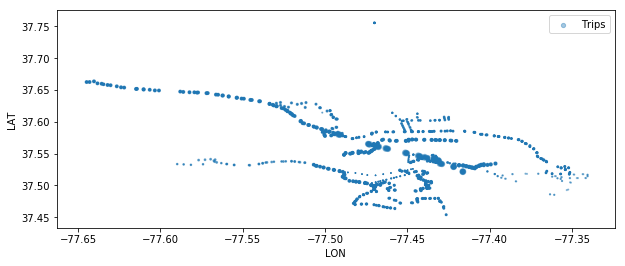

In [8]:
# Plot the LAT and LON 
# NOTE: this inital step helped to identify a number of "rounding errors" 
# Specifically there were LAT LONs (outliers) in the top-left, top-right and bottom-right of the dataset that were obvious errors and were removed using Tableau Prep

GRTC_Ridership_df.plot(kind="scatter", x="LON", y="LAT", alpha=0.4, s=GRTC_Ridership_df["TRIPS_COUNT"]/50, label="Trips",figsize=(10,4), cmap=plt.get_cmap("jet"), colorbar=False)
plt.legend()


<function matplotlib.pyplot.show(*args, **kw)>

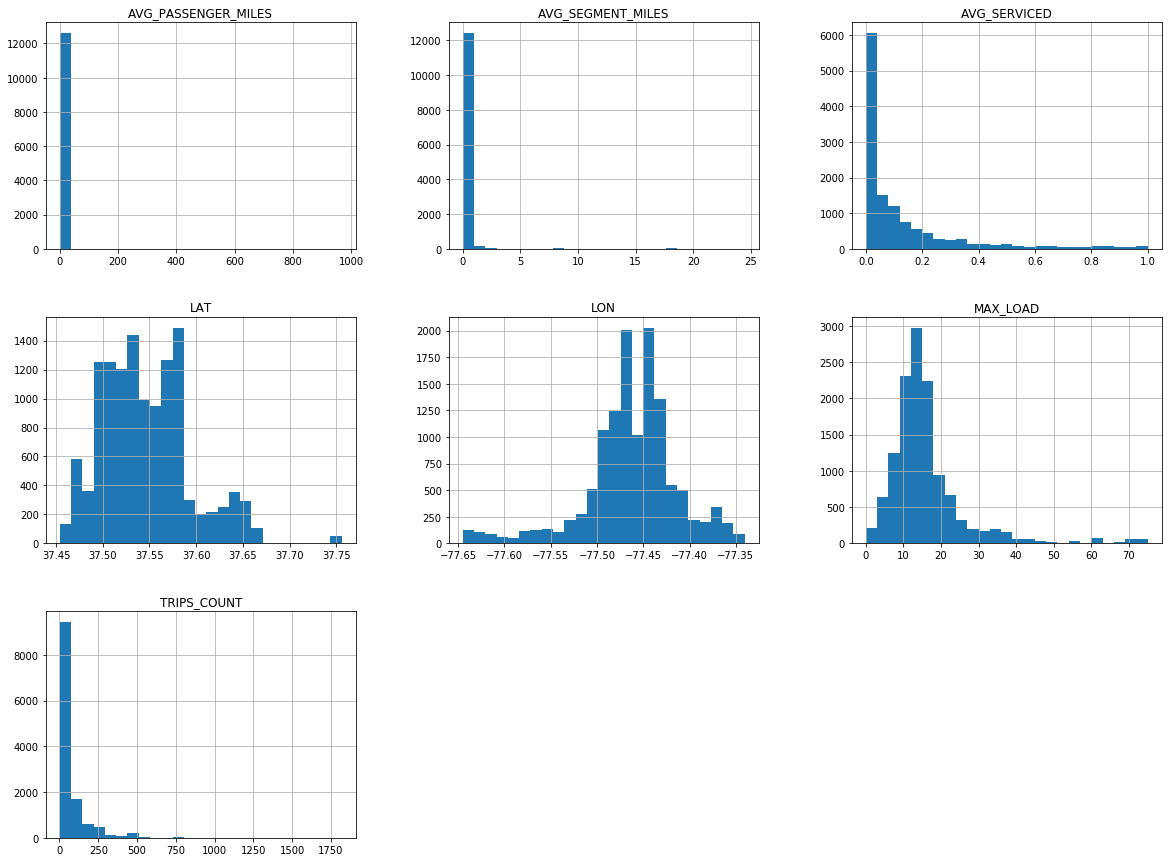

In [9]:
# Examine the spread and central tendencies visually using a histogram for each column
# NOTE the difference in ranges along the X and Y axis among the histograms which indicates some scaling will be required for most models 
GRTC_Ridership_df.hist(bins=25, figsize=(20,15))
plt.show 

#### Examine the differences between "SERVICE_TYPES" (Express vs. Local) by using Pandas groupby and aggregate on means

In [10]:
Grouped_Avg_Seg_Mi_by_Service_type_df = GRTC_Ridership_df.groupby(['SERVICE_TYPE'])[['AVG_SEGMENT_MILES']].mean()
Grouped_Avg_Seg_Mi_by_Service_type_df
# NOTE: below indicates a (larger) seperation for AVG_SEGMENT_MILES 
# Express tends to have larger AVG_SEGMENT_MILES vs. Local

,AVG_SEGMENT_MILES
SERVICE_TYPE,
Express,0.762553
Local,0.273199


In [11]:
Grouped_Avg_Pass_Mi_by_Service_type_df = GRTC_Ridership_df.groupby(['SERVICE_TYPE'])[['AVG_PASSENGER_MILES']].mean()
Grouped_Avg_Pass_Mi_by_Service_type_df
# NOTE: below indicates a (larger) seperation for AVG_PASSEGER_MILES
# Express tends to have larger AVG_PASSENGER_MILES vs. Local

,AVG_PASSENGER_MILES
SERVICE_TYPE,
Express,12.244678
Local,1.766959


In [12]:
Grouped_Avg_Serviced_by_Service_type_df = GRTC_Ridership_df.groupby(['SERVICE_TYPE'])[['AVG_SERVICED']].mean()
Grouped_Avg_Serviced_by_Service_type_df 
# NOTE: below indicates a (moderate) seperation for AVG_SERVICE (this is assumed to be a percentage 0 - 1 from histogram above) 
# Local tends to have .02% larger AVG_SERVICED over express 

,AVG_SERVICED
SERVICE_TYPE,
Express,0.110021
Local,0.133888


In [13]:
Grouped_Max_Load_by_Service_type_df = GRTC_Ridership_df.groupby(['SERVICE_TYPE'])[['MAX_LOAD']].mean()
Grouped_Max_Load_by_Service_type_df
# NOTE: below indicates a (moderate) seperation for MAX_LOAD between service types

,MAX_LOAD
SERVICE_TYPE,
Express,22.025716
Local,13.880036


In [14]:
Grouped_Trips_Count_by_Service_type_df = GRTC_Ridership_df.groupby(['SERVICE_TYPE'])[['TRIPS_COUNT']].mean()
Grouped_Trips_Count_by_Service_type_df
# NOTE: below indicates a (small) seperation for TRIPS_COUNT between service types

,TRIPS_COUNT
SERVICE_TYPE,
Express,67.698016
Local,70.604229


In [15]:
Grouped_LAT_by_Service_Type_df = GRTC_Ridership_df.groupby(['SERVICE_TYPE'])[['LAT', 'LON']].mean()
Grouped_LAT_by_Service_Type_df

,LAT,LON
SERVICE_TYPE,,
Express,37.591112,-77.517007
Local,37.533725,-77.447819


#### Examine relationships between variables using Pandas correlation and covariance matrix

In [16]:
# Examine DataFrame using a correlation matrix (.corr)
# NOTE:A measure used to represent how strongly two random variables are related known as correlation.
# NOTE: in the results below AVG_SEGMENT_MILES most correlated to AVG_PASSENGER_MILES (0.761304)
# Other relationship to note is between MAX_LOAD and TRIPS_COUNT (0.297648)
# MAX_LOAD and AVG_SERVICED (0.269880)
# AVG_SERVICED and TRIPS_COUNT (0.264000)
# AVG_SEGMENT_MILES and MAX_LOAD (0.170514)
# It is expected that modeles will "weight" these relationships higher in predicting Local vs. Express

GRTC_Ridership_df.corr()

,TRIPS_COUNT,AVG_SERVICED,MAX_LOAD,AVG_PASSENGER_MILES,AVG_SEGMENT_MILES,LAT,LON
TRIPS_COUNT,1.000000,0.264000,0.297648,-0.010366,-0.010465,0.082157,-0.043010
AVG_SERVICED,0.264000,1.000000,0.269880,0.025293,0.041829,0.049201,0.068710
MAX_LOAD,0.297648,0.269880,1.000000,0.276367,0.170514,0.130199,-0.010913
AVG_PASSENGER_MILES,-0.010366,0.025293,0.276367,1.000000,0.761304,0.153283,0.001117
AVG_SEGMENT_MILES,-0.010465,0.041829,0.170514,0.761304,1.000000,0.180303,-0.012152
LAT,0.082157,0.049201,0.130199,0.153283,0.180303,1.000000,-0.472150
LON,-0.043010,0.068710,-0.010913,0.001117,-0.012152,-0.472150,1.000000


In [17]:
# Examine DataFrame using a covariance matrix (.cov)
# NOTE: A measure used to indicate the extent to which two random variables change in tandem is known as covariance. 
# Unlike correlation (unit less) this includes the respective varible units
GRTC_Ridership_df.cov()

,TRIPS_COUNT,AVG_SERVICED,MAX_LOAD,AVG_PASSENGER_MILES,AVG_SEGMENT_MILES,LAT,LON
TRIPS_COUNT,15832.927993,6.828375,394.195475,-42.466630,-1.731887,0.493089,-0.273085
AVG_SERVICED,6.828375,0.042254,0.583892,0.169276,0.011308,0.000482,0.000713
MAX_LOAD,394.195475,0.583892,110.778461,94.705029,2.360312,0.065363,-0.005796
AVG_PASSENGER_MILES,-42.466630,0.169276,94.705029,1060.028441,32.598610,0.238041,0.001834
AVG_SEGMENT_MILES,-1.731887,0.011308,2.360312,32.598610,1.729674,0.011311,-0.000806
LAT,0.493089,0.000482,0.065363,0.238041,0.011311,0.002275,-0.001136
LON,-0.273085,0.000713,-0.005796,0.001834,-0.000806,-0.001136,0.002546


#### Examine Correlation Visually using a scatter matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5F258B278>,
      dtype=object)

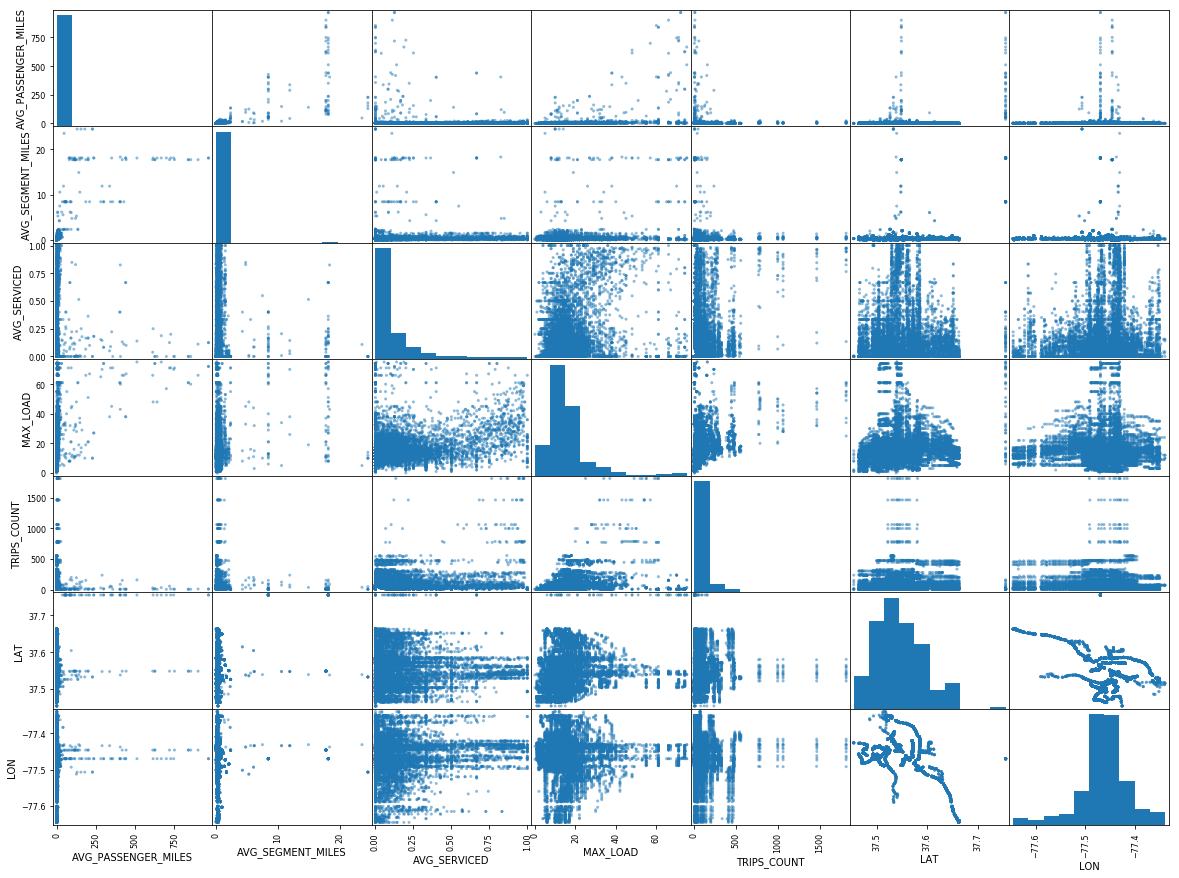

In [18]:
# Relationships between variables can be examined visually using a scatter_matrix
attributes = ["AVG_PASSENGER_MILES", "AVG_SEGMENT_MILES", "AVG_SERVICED", "MAX_LOAD", "TRIPS_COUNT", "LAT", "LON"]
scatter_matrix(GRTC_Ridership_df[attributes], figsize=(20,15)) 

### Prepare the data to better expose the underlying data patterns to Machine Learning algorithms
Assign data to X and y

Scale the data using standardization as needed

Split the Data into a training and test set

In [19]:
# Assign X (data) and y (target)
X = GRTC_Ridership_df.drop(["SERVICE_TYPE"], axis=1)
y = GRTC_Ridership_df["SERVICE_TYPE"]
print(X.shape, y.shape)

(12700, 7) (12700,)


In [20]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, stratify=y)

print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)
#NOTE the size of the training set is 9,525 rows while the size of the test set is 3,175) 
# About 75% of the total data is used for training the model while 25% is set aside for testing

(9525, 7) (9525,) (3175, 7) (3175,)


In [21]:
# Reshape y_train and y_test to allow for later tranform to 0 and 1
y_test_encoder = y_test.values.reshape(-1, 1)
y_train_encoder = y_train.values.reshape(-1, 1) 

In [22]:
# In some cases below y_train needs to be encoded to 0 for express and 1 for local
ordinal_encoder = OrdinalEncoder()
y_train_encoder = ordinal_encoder.fit_transform(y_train_encoder)
y_train_encoder

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

In [23]:
# In some cases below y_test needs to be encoded to 0 for express and 1 for local
# Use the OrdinalEncoder to create the transform
ordinal_encoder = OrdinalEncoder()
y_test_encoder = ordinal_encoder.fit_transform(y_test_encoder)
y_test_encoder

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

### Explore different models and short-list the best one(s)
This problem was identified as a Supervised Machine Learning as we have have dataset with known outcomes and model is seeking to categorize the output class (which is binary)

The following classifiers (models) were evaluated:
 - Logistics Regress
 - K Nearest Neighbors (KNN)
 - Support Vector Machine (SVM)
 - Random Forest (Ensemble of Decisions Trees)

#### Logistics Regression

In [24]:
# Create a Logistics Regression Model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
classifier.fit(X_train, y_train_encoder)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
print(f"Training Data Score: {classifier.score(X_train, y_train_encoder)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test_encoder)}")

Training Data Score: 0.8161679790026247
Testing Data Score: 0.8116535433070866


In [27]:
y_test_encoder_list = y_test_encoder.tolist()

In [28]:
# Make predictions
predictions_log = classifier.predict(X_test)
results_log = pd.DataFrame({"Prediction": predictions_log, "Actual": y_test_encoder_list}).reset_index(drop=True) 
results_log.head

<bound method NDFrame.head of       Prediction Actual
0            1.0  [1.0]
1            1.0  [1.0]
2            1.0  [1.0]
3            1.0  [1.0]
4            1.0  [1.0]
5            1.0  [1.0]
6            1.0  [1.0]
7            1.0  [1.0]
8            1.0  [0.0]
9            1.0  [1.0]
10           1.0  [0.0]
11           1.0  [1.0]
12           1.0  [1.0]
13           1.0  [1.0]
14           1.0  [1.0]
15           0.0  [0.0]
16           1.0  [1.0]
17           1.0  [1.0]
18           1.0  [1.0]
19           1.0  [1.0]
20           1.0  [1.0]
21           1.0  [0.0]
22           1.0  [0.0]
23           1.0  [1.0]
24           1.0  [1.0]
25           1.0  [1.0]
26           0.0  [0.0]
27           1.0  [0.0]
28           1.0  [1.0]
29           1.0  [1.0]
...          ...    ...
3145         1.0  [0.0]
3146         1.0  [1.0]
3147         1.0  [1.0]
3148         1.0  [1.0]
3149         1.0  [1.0]
3150         1.0  [1.0]
3151         1.0  [1.0]
3152         1.0  [1.0]
3153      

In [29]:
# Reshape predictions for use in metrics calculations below
predictions_log_encoder = predictions_log.reshape(-1, 1) 

In [30]:
# Transform predictions to 0 and 1 using OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
predictions_log_encoder = ordinal_encoder.fit_transform(predictions_log_encoder)

In [31]:
print(f"accuracy: {accuracy_score(y_test_encoder, predictions_log_encoder)}")

accuracy: 0.8116535433070866


In [32]:
print(f"mean squared error: {mean_squared_error(y_test_encoder, predictions_log_encoder)}") 

mean squared error: 0.1883464566929134


In [33]:
new_route_data = [[69, .15, 10, 5, .25, 37.546025, -77.462649]] 
predicted_class_log = classifier.predict(new_route_data)
print(f"prediction: {predicted_class_log} where 1 is local and 0 is express")

prediction: [1.] where 1 is local and 0 is express


#### K Nearest Neighbors (KNN)

In [34]:
# Dependencies
from sklearn.neighbors import KNeighborsClassifier

In [35]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train.values.reshape(-1, 1))

In [36]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.962
k: 3, Train/Test Score: 0.975/0.941
k: 5, Train/Test Score: 0.959/0.939
k: 7, Train/Test Score: 0.951/0.933
k: 9, Train/Test Score: 0.945/0.929
k: 11, Train/Test Score: 0.940/0.924
k: 13, Train/Test Score: 0.935/0.921
k: 15, Train/Test Score: 0.930/0.920
k: 17, Train/Test Score: 0.926/0.917
k: 19, Train/Test Score: 0.922/0.914
k: 21, Train/Test Score: 0.919/0.913
k: 23, Train/Test Score: 0.913/0.911
k: 25, Train/Test Score: 0.908/0.905
k: 27, Train/Test Score: 0.908/0.905
k: 29, Train/Test Score: 0.904/0.898
k: 31, Train/Test Score: 0.901/0.896
k: 33, Train/Test Score: 0.899/0.895


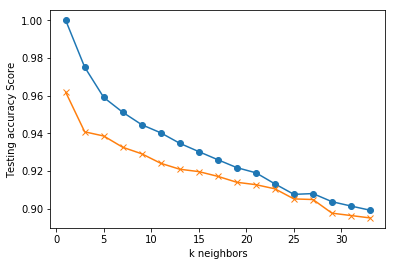

In [37]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 35, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_encoder)
    train_score = knn.score(X_train_scaled, y_train_encoder)
    test_score = knn.score(X_test_scaled, y_test_encoder)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 35, 2), train_scores, marker='o')
plt.plot(range(1, 35, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [38]:
# Note that k:17 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=17)
classifier = knn
knn.fit(X_train_scaled, y_train_encoder) 
print('k=17 Test Acc: %.3f' % knn.score(X_test_scaled, y_test_encoder))

k=17 Test Acc: 0.917


In [39]:
# Make predictions
predictions_knn = classifier.predict(X_test_scaled)
predictions_knn_list = predictions_knn.tolist()

In [40]:
results_knn = pd.DataFrame({"Prediction": predictions_knn, "Actual": y_test_encoder_list}).reset_index(drop=True)
results_knn.head(20) 

,Prediction,Actual
0,1.0,[1.0]
1,1.0,[1.0]
2,1.0,[1.0]
3,1.0,[1.0]
4,0.0,[1.0]
5,1.0,[1.0]
6,1.0,[1.0]
7,1.0,[1.0]
8,0.0,[0.0]
9,1.0,[1.0]


In [41]:
print(f"accuracy: {accuracy_score(y_test_encoder_list, predictions_knn_list, )}")

accuracy: 0.9171653543307087


In [42]:
print(f"mean squared error: {mean_squared_error(y_test_encoder_list, predictions_knn_list)}") 

mean squared error: 0.08283464566929134


In [43]:
new_route_data = [[69, .15, 10, 5, .25, 37.546025, -77.462649]] 
predicted_class_knn = knn.predict(new_route_data)
print(f"prediction: {predicted_class_knn} where 1 is local and 0 is express")

prediction: [1.] where 1 is local and 0 is express


#### Support Vector Machine (SVM)

The Support Vector Machine seeks to seperate the classes (in this case Express and Local) using the "widest road possible"

In [44]:
# Show the column headers to assist in code development (not needed after that)
# GRTC_Ridership_df.head()

In [45]:
# Using the same X and y data from above refine for use with SVM
target = GRTC_Ridership_df["SERVICE_TYPE"]
target_names = ["express", "local"] 

In [46]:
# Support vector machine linear classifier
from sklearn.svm import SVC 

In [47]:
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train_encoder)
predictions_SVC = model.predict(X_test_scaled)
predictions_SVC

array([1., 1., 1., ..., 1., 1., 1.])

In [48]:
results_SVC = pd.DataFrame({"Prediction": predictions_SVC, "Actual": y_test_encoder_list}).reset_index(drop=True)
results_SVC.head(10)

,Prediction,Actual
0,1.0,[1.0]
1,1.0,[1.0]
2,1.0,[1.0]
3,1.0,[1.0]
4,1.0,[1.0]
5,1.0,[1.0]
6,1.0,[1.0]
7,1.0,[1.0]
8,1.0,[0.0]
9,1.0,[1.0]


In [49]:
# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_encoder, predictions_SVC,
                            target_names=["express", "local"]))

              precision    recall  f1-score   support

     express       0.91      0.09      0.16       680
       local       0.80      1.00      0.89      2495

    accuracy                           0.80      3175
   macro avg       0.85      0.54      0.52      3175
weighted avg       0.82      0.80      0.73      3175



In [50]:
# Model Accuracy
print('Test Acc: %.3f' % model.score(X_test_scaled, y_test_encoder))

Test Acc: 0.803


In [51]:
#Model Accuracy is the same as percision
precision_score(y_test_encoder, predictions_SVC, average='micro')

0.8028346456692913

In [52]:
#Model Recall
print(f"recall_score: {recall_score(y_test_encoder, predictions_SVC)}")

recall_score: 0.9975951903807615


In [53]:
# Compute the model's "combined" f1_score
print(f"f1-score: {f1_score(y_test_encoder, predictions_SVC)}")

f1-score: 0.8882940756602425


In [54]:
# Model MSE
print(f"mean squared error: {mean_squared_error(y_test_encoder, predictions_SVC)}") 

mean squared error: 0.19716535433070867


#### Random Forest Classifier
The Random Forest Classifier is an ensemble of Decision Trees.  The idea with this classifier is it "learns" using multiple independent predictors (each using a random sample of the training set (with replacement (i.e. bootstrap). Each predictor "learns" which factors best assist in making a prediction and the predictors collectively vote on ultimate prediction make.


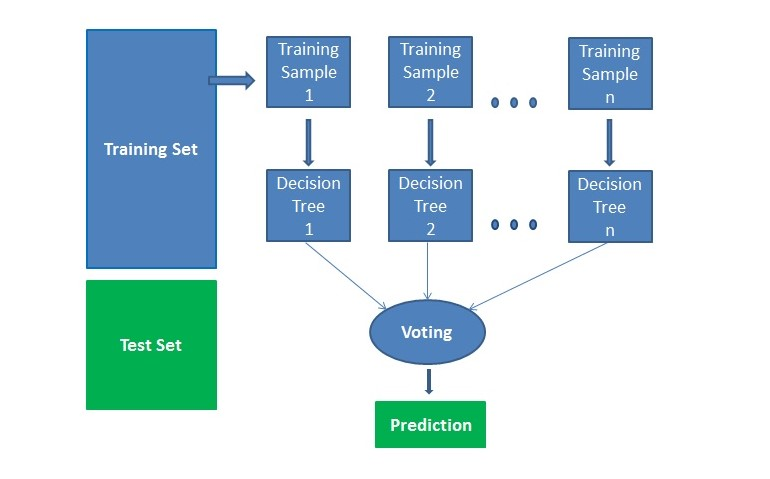

In [55]:
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier 

In [56]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred_rfc=clf.predict(X_test)

In [57]:
y_pred_rfc

array(['Local', 'Local', 'Local', ..., 'Local', 'Local', 'Local'],
      dtype=object)

In [58]:
print(f"Accuracy for rfc: {metrics.accuracy_score(y_test, y_pred_rfc)}")

Accuracy for rfc: 0.9908661417322835


In [59]:
results_rfc = pd.DataFrame({"Prediction": y_pred_rfc, "Actual": y_test}).reset_index(drop=True)
results_rfc

,Prediction,Actual
0,Local,Local
1,Local,Local
2,Local,Local
3,Local,Local
4,Local,Local
5,Local,Local
6,Local,Local
7,Local,Local
8,Express,Express
9,Local,Local


In [60]:
# Calculate classification report

print(classification_report(y_test, y_pred_rfc,
                            target_names=["express", "local"]))

              precision    recall  f1-score   support

     express       0.98      0.97      0.98       680
       local       0.99      1.00      0.99      2495

    accuracy                           0.99      3175
   macro avg       0.99      0.99      0.99      3175
weighted avg       0.99      0.99      0.99      3175



In [61]:
for name, score in zip(X_test, clf.feature_importances_):
    print(name, score)

TRIPS_COUNT 0.07544092910536776
AVG_SERVICED 0.03492787202590261
MAX_LOAD 0.12607435318470783
AVG_PASSENGER_MILES 0.06591761541952809
AVG_SEGMENT_MILES 0.062240023442626774
LAT 0.3150175543026481
LON 0.32038165251921874


In [62]:
# Save the model using Python's pickle module or using joblib
# ex. dump(clf, 'filename.joblib')

In [63]:
# load back the pickled model (possibly in another Python process) with:
# ex. clf = load('filename.joblib') 